# The Ensemble Method

In [2]:
#hyper params
lr = 1e-4
bs = 32
val_split = 0.85
num_epoch = 20
num_classes = 32

In [3]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn import svm
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score
import torch

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Not connected to a GPU runtime.")

Running on GPU


In [13]:
!unzip homus_split.zip

Streaming output truncated to the last 5000 lines.
  inflating: homus_split/train/Quarter-Note/22-97_3.png  
  inflating: homus_split/train/Quarter-Note/22-98_3.png  
  inflating: homus_split/train/Quarter-Note/22-99_3.png  
  inflating: homus_split/train/Quarter-Note/23-93_3.png  
  inflating: homus_split/train/Quarter-Note/23-94_3.png  
  inflating: homus_split/train/Quarter-Note/23-95_3.png  
  inflating: homus_split/train/Quarter-Note/23-96_3.png  
  inflating: homus_split/train/Quarter-Note/23-97_3.png  
  inflating: homus_split/train/Quarter-Note/23-98_3.png  
  inflating: homus_split/train/Quarter-Note/23-99_3.png  
  inflating: homus_split/train/Quarter-Note/24-100_3.png  
  inflating: homus_split/train/Quarter-Note/24-93_3.png  
  inflating: homus_split/train/Quarter-Note/24-94_3.png  
  inflating: homus_split/train/Quarter-Note/24-95_3.png  
  inflating: homus_split/train/Quarter-Note/24-96_3.png  
  inflating: homus_split/train/Quarter-Note/24-97_3.png  
  inflating: homus_s

In [5]:
def get_TVT(path):
    data_transforms = transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(path+'train/',transform=data_transforms)

    train_size = math.floor(len(dataset)*val_split)
    val_size = len(dataset) - train_size
    trainset, valset = data.random_split(dataset,lengths=[train_size,val_size])
    testset = datasets.ImageFolder(path+'test/',transform=data_transforms)
    return trainset,valset,testset

In [6]:
def train_model(trainset, valset, model, criterion, optimizer, scheduler, num_epochs):

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    dataloaders = {
        'train': data.DataLoader(trainset,batch_size=bs,shuffle=True),
        'val' : data.DataLoader(valset,batch_size=bs,shuffle=True)
    }
    dataset_sizes = {'train':len(trainset),'val':len(valset)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                #print('bruh')

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'val':
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)
            else:
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


        print()

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plotting the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), [acc.item() for acc in train_accs], label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), [acc.item() for acc in val_accs], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def test_acc(model, testset):
    running_corrects = 0
    testloader = data.DataLoader(testset,batch_size=bs,shuffle=True)
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
    return (running_corrects/len(testset))

In [8]:
def get_weighted_score_ft(models,dataset):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader = data.DataLoader(dataset,batch_size=1,shuffle=True)
    for inputs,labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        predictions = set()
        with torch.set_grad_enabled(False):
            x = models[0](inputs)
            _, preds = torch.max(x, 1)
            predictions.add(preds)
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                x = torch.cat((x,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,x.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,x.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)
    return X,Y


In [9]:
def get_models():
    googlenet = torchvision.models.googlenet(pretrained=True)
    resnet = torchvision.models.resnet50(pretrained=True)
    densenet = torchvision.models.densenet161(pretrained=True)

    densenet.classifier = nn.Linear(2208,num_classes)
    resnet.fc = nn.Linear(2048,num_classes)
    googlenet.fc = nn.Linear(1024,num_classes)
    densenet = densenet.to(device)
    resnet = resnet.to(device)
    googlenet = googlenet.to(device)

    return [densenet,googlenet,resnet]

In [10]:
def check_trainable_layers(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)


In [11]:
import torchvision.models as models
import torch.nn as nn
'''
def get_models():
    googlenet = models.googlenet(pretrained=True)
    resnet = models.resnet50(pretrained=True)
    densenet = models.densenet161(pretrained=True)

    # Set requires_grad=False for all parameters except the last layer
    for param in googlenet.parameters():
        param.requires_grad = False
    for param in resnet.parameters():
        param.requires_grad = False
    for param in densenet.parameters():
        param.requires_grad = False

    # Modify the last layer of each model
    densenet.classifier = nn.Linear(2208, num_classes)
    resnet.fc = nn.Linear(2048, num_classes)
    googlenet.fc = nn.Linear(1024, num_classes)

    densenet = densenet.to(device)
    resnet = resnet.to(device)
    googlenet = googlenet.to(device)

    return [densenet, googlenet, resnet]
'''

'\ndef get_models():\n    googlenet = models.googlenet(pretrained=True)\n    resnet = models.resnet50(pretrained=True)\n    densenet = models.densenet161(pretrained=True)\n\n    # Set requires_grad=False for all parameters except the last layer\n    for param in googlenet.parameters():\n        param.requires_grad = False\n    for param in resnet.parameters():\n        param.requires_grad = False\n    for param in densenet.parameters():\n        param.requires_grad = False\n\n    # Modify the last layer of each model\n    densenet.classifier = nn.Linear(2208, num_classes)\n    resnet.fc = nn.Linear(2048, num_classes)\n    googlenet.fc = nn.Linear(1024, num_classes)\n\n    densenet = densenet.to(device)\n    resnet = resnet.to(device)\n    googlenet = googlenet.to(device)\n\n    return [densenet, googlenet, resnet]\n'

In [14]:
'''
criterion = nn.CrossEntropyLoss()
ensemble_accuracy=[]
for fold in ['Fold_1','Fold_2','Fold_3','Fold_4','Fold_5']:
    for folder in  ['homus_data']: #['Capitan_Score_Non-uniform','Capitan_Score_Uniform','Fornes_Music_Symbols_labelled']['Rebelo_Syn_labelled']:
        trainset,valset,testset = get_TVT('homus_data'+fold+'/',folder)
        #models = get_models()
        for model in models:
            optimizer = optim.Adam(model.parameters(),lr=lr)
            exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)
            model = train_model(trainset, valset, model, criterion, optimizer, exp_lr_scheduler,num_epoch)

            print(test_acc(model,testset))
    train_X, train_Y = get_weighted_score_ft(models,trainset)
    test_X, test_Y = get_weighted_score_ft(models,testset)
    clf = svm.SVC(kernel='rbf',break_ties=True).fit(train_X, train_Y)
    pred = clf.predict(test_X)
    acc = accuracy_score(test_Y, pred)
    ensemble_accuracy.append(acc)
    print('Ensemble on '+fold+': '+str(acc))
print("Average Ensemble Accuracy:",sum(ensemble_accuracy)/len(ensemble_accuracy))
'''

'\ncriterion = nn.CrossEntropyLoss()\nensemble_accuracy=[]\nfor fold in [\'Fold_1\',\'Fold_2\',\'Fold_3\',\'Fold_4\',\'Fold_5\']:\n    for folder in  [\'homus_data\']: #[\'Capitan_Score_Non-uniform\',\'Capitan_Score_Uniform\',\'Fornes_Music_Symbols_labelled\'][\'Rebelo_Syn_labelled\']:\n        trainset,valset,testset = get_TVT(\'homus_data\'+fold+\'/\',folder)\n        #models = get_models()\n        for model in models:\n            optimizer = optim.Adam(model.parameters(),lr=lr)\n            exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)\n            model = train_model(trainset, valset, model, criterion, optimizer, exp_lr_scheduler,num_epoch)\n\n            print(test_acc(model,testset))\n    train_X, train_Y = get_weighted_score_ft(models,trainset)\n    test_X, test_Y = get_weighted_score_ft(models,testset)\n    clf = svm.SVC(kernel=\'rbf\',break_ties=True).fit(train_X, train_Y)\n    pred = clf.predict(test_X)\n    acc = accuracy_score(test_Y, pred)\n  

In [11]:
models = get_models()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 49.9MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be remo

In [12]:
check_trainable_layers(models[0])

features.conv0.weight
features.norm0.weight
features.norm0.bias
features.denseblock1.denselayer1.norm1.weight
features.denseblock1.denselayer1.norm1.bias
features.denseblock1.denselayer1.conv1.weight
features.denseblock1.denselayer1.norm2.weight
features.denseblock1.denselayer1.norm2.bias
features.denseblock1.denselayer1.conv2.weight
features.denseblock1.denselayer2.norm1.weight
features.denseblock1.denselayer2.norm1.bias
features.denseblock1.denselayer2.conv1.weight
features.denseblock1.denselayer2.norm2.weight
features.denseblock1.denselayer2.norm2.bias
features.denseblock1.denselayer2.conv2.weight
features.denseblock1.denselayer3.norm1.weight
features.denseblock1.denselayer3.norm1.bias
features.denseblock1.denselayer3.conv1.weight
features.denseblock1.denselayer3.norm2.weight
features.denseblock1.denselayer3.norm2.bias
features.denseblock1.denselayer3.conv2.weight
features.denseblock1.denselayer4.norm1.weight
features.denseblock1.denselayer4.norm1.bias
features.denseblock1.denselaye

In [15]:
trainset,valset,testset = get_TVT('homus_split/')

Epoch 1/20
----------
train Loss: 0.6590 Acc: 0.8296
val Loss: 0.2155 Acc: 0.9304

Epoch 2/20
----------
train Loss: 0.1586 Acc: 0.9486
val Loss: 0.2042 Acc: 0.9366

Epoch 3/20
----------
train Loss: 0.1005 Acc: 0.9682
val Loss: 0.1112 Acc: 0.9643

Epoch 4/20
----------
train Loss: 0.0679 Acc: 0.9780
val Loss: 0.1513 Acc: 0.9513

Epoch 5/20
----------
train Loss: 0.0709 Acc: 0.9767
val Loss: 0.1221 Acc: 0.9626

Epoch 6/20
----------
train Loss: 0.0673 Acc: 0.9794
val Loss: 0.1546 Acc: 0.9536

Epoch 7/20
----------
train Loss: 0.0388 Acc: 0.9878
val Loss: 0.1345 Acc: 0.9581

Epoch 8/20
----------
train Loss: 0.0346 Acc: 0.9901
val Loss: 0.1481 Acc: 0.9587

Epoch 9/20
----------
train Loss: 0.0292 Acc: 0.9911
val Loss: 0.1830 Acc: 0.9451

Epoch 10/20
----------
train Loss: 0.0125 Acc: 0.9972
val Loss: 0.0956 Acc: 0.9711

Epoch 11/20
----------
train Loss: 0.0057 Acc: 0.9989
val Loss: 0.0951 Acc: 0.9694

Epoch 12/20
----------
train Loss: 0.0034 Acc: 0.9996
val Loss: 0.0895 Acc: 0.9723

E

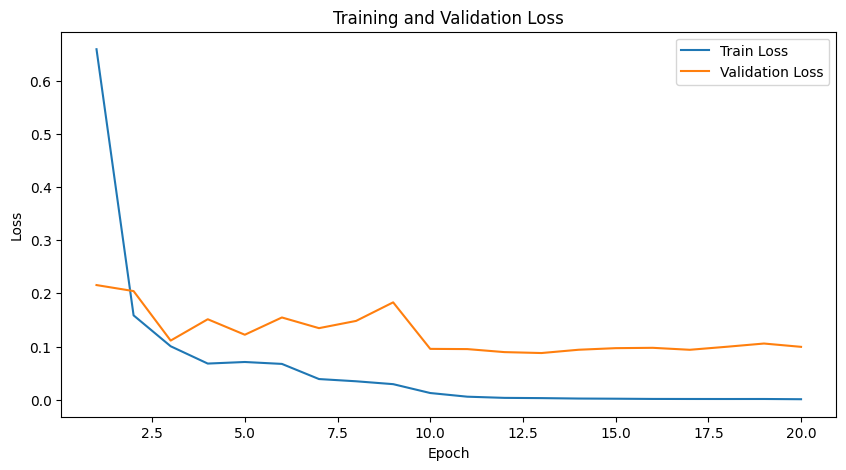

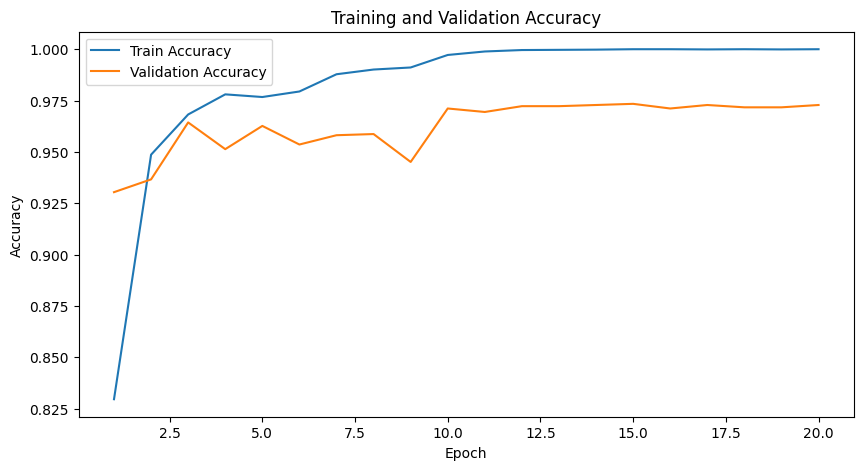

Training complete in 20m 13s
Best val Acc: 0.973401
Final Accuracy:  tensor(0.9776, device='cuda:0')
Epoch 1/20
----------
train Loss: 1.2930 Acc: 0.6846
val Loss: 0.3060 Acc: 0.9106

Epoch 2/20
----------
train Loss: 0.2645 Acc: 0.9215
val Loss: 0.2306 Acc: 0.9191

Epoch 3/20
----------
train Loss: 0.1406 Acc: 0.9583
val Loss: 0.1624 Acc: 0.9445

Epoch 4/20
----------
train Loss: 0.0879 Acc: 0.9749
val Loss: 0.1480 Acc: 0.9445

Epoch 5/20
----------
train Loss: 0.0695 Acc: 0.9806
val Loss: 0.1508 Acc: 0.9479

Epoch 6/20
----------
train Loss: 0.0508 Acc: 0.9864
val Loss: 0.1459 Acc: 0.9547

Epoch 7/20
----------
train Loss: 0.0388 Acc: 0.9893
val Loss: 0.2092 Acc: 0.9360

Epoch 8/20
----------
train Loss: 0.0417 Acc: 0.9872
val Loss: 0.1928 Acc: 0.9474

Epoch 9/20
----------
train Loss: 0.0371 Acc: 0.9893
val Loss: 0.1535 Acc: 0.9542

Epoch 10/20
----------
train Loss: 0.0147 Acc: 0.9969
val Loss: 0.1383 Acc: 0.9564

Epoch 11/20
----------
train Loss: 0.0084 Acc: 0.9986
val Loss: 0.12

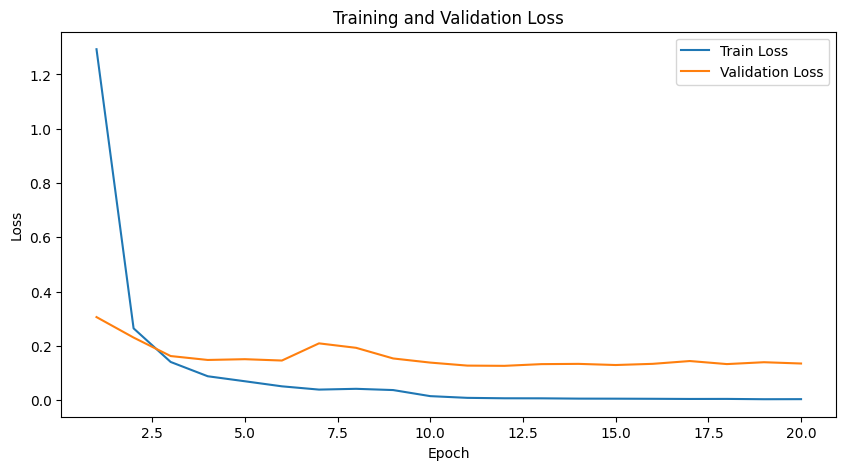

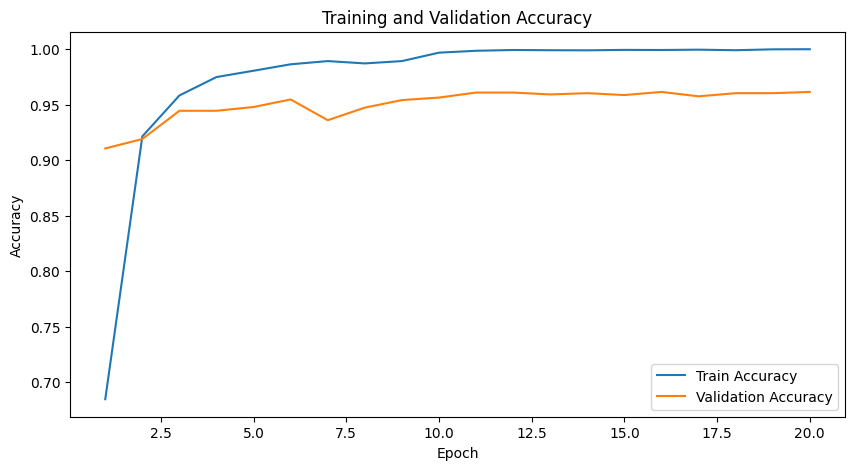

Training complete in 6m 26s
Best val Acc: 0.961517
Final Accuracy:  tensor(0.9628, device='cuda:0')
Epoch 1/20
----------
train Loss: 0.6860 Acc: 0.8019
val Loss: 0.2092 Acc: 0.9287

Epoch 2/20
----------
train Loss: 0.2021 Acc: 0.9332
val Loss: 0.2994 Acc: 0.9089

Epoch 3/20
----------
train Loss: 0.1309 Acc: 0.9576
val Loss: 0.1495 Acc: 0.9496

Epoch 4/20
----------
train Loss: 0.1107 Acc: 0.9626
val Loss: 0.1753 Acc: 0.9462

Epoch 5/20
----------
train Loss: 0.0772 Acc: 0.9765
val Loss: 0.1695 Acc: 0.9502

Epoch 6/20
----------
train Loss: 0.0741 Acc: 0.9756
val Loss: 0.2022 Acc: 0.9360

Epoch 7/20
----------
train Loss: 0.0544 Acc: 0.9831
val Loss: 0.1804 Acc: 0.9508

Epoch 8/20
----------
train Loss: 0.0606 Acc: 0.9812
val Loss: 0.1824 Acc: 0.9502

Epoch 9/20
----------
train Loss: 0.0435 Acc: 0.9853
val Loss: 0.1634 Acc: 0.9570

Epoch 10/20
----------
train Loss: 0.0151 Acc: 0.9950
val Loss: 0.1211 Acc: 0.9655

Epoch 11/20
----------
train Loss: 0.0082 Acc: 0.9981
val Loss: 0.119

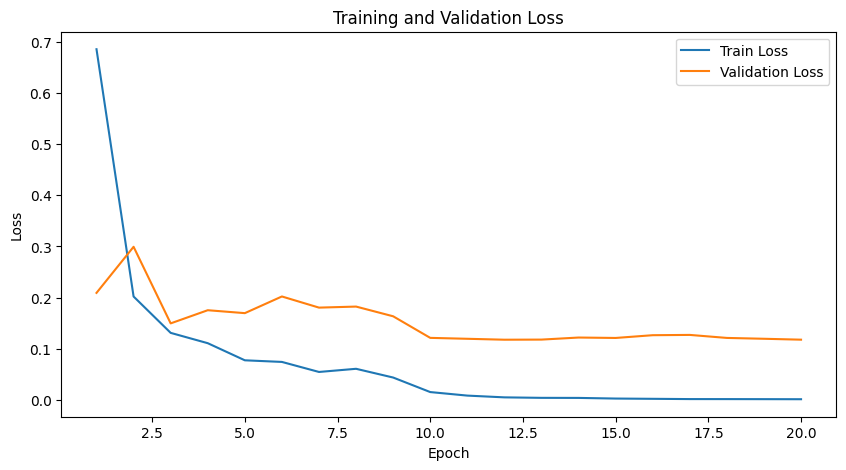

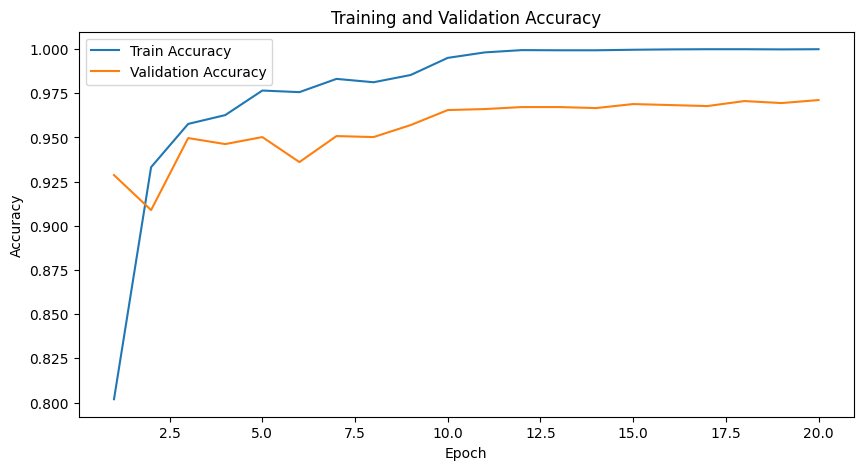

Training complete in 11m 26s
Best val Acc: 0.971138
Final Accuracy:  tensor(0.9700, device='cuda:0')


In [16]:
criterion = nn.CrossEntropyLoss()
for model in models[:]:
            optimizer = optim.Adam(model.parameters(),lr=lr)
            exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)
            model = train_model(trainset, valset, model, criterion, optimizer, exp_lr_scheduler,num_epoch)
            model_filename = "model_{}.pt".format(model.__class__.__name__)  # You can modify the filename as needed
            torch.save(model.state_dict(), model_filename)
            print("Final Accuracy: ",test_acc(model,testset))

In [65]:
train_X, train_Y = get_weighted_score_ft(models,trainset)
test_X, test_Y = get_weighted_score_ft(models,testset)
clf = svm.SVC(kernel='rbf',break_ties=True).fit(train_X, train_Y)
pred = clf.predict(test_X)
acc = accuracy_score(test_Y, pred)
print("Ensemble Accuracy: ", acc)

Ensemble Accuracy:  0.9789126853377266


In [18]:
from sklearn.tree import DecisionTreeClassifier

clf2 = DecisionTreeClassifier().fit(train_X, train_Y)
pred2 = clf2.predict(test_X)
acc2 = accuracy_score(test_Y, pred2)
print("Decision Tree-based Ensemble Accuracy: ", acc2)

Decision Tree-based Ensemble Accuracy:  0.9525535420098846


In [19]:
from sklearn.ensemble import RandomForestClassifier

clf3 = RandomForestClassifier().fit(train_X, train_Y)
pred3 = clf3.predict(test_X)
acc3 = accuracy_score(test_Y, pred3)
print("Random Forest-based Ensemble Accuracy: ", acc3)

Random Forest-based Ensemble Accuracy:  0.9769357495881383


In [20]:
!pip install xgboost
import xgboost as xgb

clf4 = xgb.XGBClassifier().fit(train_X, train_Y)
pred4 = clf4.predict(test_X)
acc4 = accuracy_score(test_Y, pred4)
print("XGboost-based Ensemble Accuracy: ", acc4)

XGboost-based Ensemble Accuracy:  0.9683690280065897


In [21]:
from sklearn.naive_bayes import GaussianNB

clf5 = GaussianNB().fit(train_X, train_Y)
pred5 = clf5.predict(test_X)
acc5 = accuracy_score(test_Y, pred5)
print("Naive Bayes-based Ensemble Accuracy: ", acc5)

Naive Bayes-based Ensemble Accuracy:  0.9739703459637562


In [22]:
from sklearn.ensemble import AdaBoostClassifier

base_classifier = DecisionTreeClassifier()
clf6 = AdaBoostClassifier(base_estimator=base_classifier).fit(train_X, train_Y)
pred6 = clf6.predict(test_X)
acc6 = accuracy_score(test_Y, pred6)
print("Adaboost-based Ensemble Accuracy: ", acc6)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Adaboost-based Ensemble Accuracy:  0.9542009884678748


In [23]:
from sklearn.neighbors import KNeighborsClassifier

clf7 = KNeighborsClassifier(n_neighbors=2).fit(train_X, train_Y)
pred7 = clf7.predict(test_X)
acc7 = accuracy_score(test_Y, pred7)
print("KNN(n=2)-based Ensemble Accuracy: ", acc7)

KNN(n=2)-based Ensemble Accuracy:  0.9789126853377266


In [24]:
from sklearn.neighbors import NearestCentroid

clf8 = NearestCentroid().fit(train_X, train_Y)
pred8 = clf8.predict(test_X)
acc8 = accuracy_score(test_Y, pred8)
print("Nearest Centroid-based Ensemble Accuracy: ", acc8)

Nearest Centroid-based Ensemble Accuracy:  0.9795716639209225


In [25]:
def get_weighted_score_clf(clf, dataset):
    data_loader = data.DataLoader(dataset, batch_size=bs, shuffle=False)

    # Initialize empty lists to store the predictions and true labels (if available)
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)

            # Get the raw scores or probabilities from the classifier
            outputs = clf(inputs)

            # Append the scores/probabilities to the predictions list
            predictions.append(outputs.cpu().numpy())

            # Append the true labels to the true_labels list (if available)
            if labels is not None:
                true_labels.append(labels.numpy())

    # Concatenate the predictions and true labels (if available)
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0) if len(true_labels) > 0 else None

    return predictions, true_labels


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [70]:
train_X1 = clf.predict(train_X).reshape(-1, 1)
train_X2 = clf2.predict(train_X).reshape(-1, 1)
train_X3 = clf3.predict(train_X).reshape(-1, 1)
train_X4 = clf4.predict(train_X).reshape(-1, 1)
train_X5 = clf5.predict(train_X).reshape(-1, 1)
train_X6 = clf6.predict(train_X).reshape(-1, 1)
train_X7 = clf7.predict(train_X).reshape(-1, 1)
train_X8 = clf8.predict(train_X).reshape(-1, 1)
train_cls_X = np.concatenate((train_X1, train_X2, train_X3, train_X4, train_X5, train_X6, train_X7, train_X8), axis=1)

In [71]:
test_X1 = clf.predict(test_X).reshape(-1, 1)
test_X2 = clf2.predict(test_X).reshape(-1, 1)
test_X3 = clf3.predict(test_X).reshape(-1, 1)
test_X4 = clf4.predict(test_X).reshape(-1, 1)
test_X5 = clf5.predict(test_X).reshape(-1, 1)
test_X6 = clf6.predict(test_X).reshape(-1, 1)
test_X7 = clf7.predict(test_X).reshape(-1, 1)
test_X8 = clf8.predict(test_X).reshape(-1, 1)
test_cls_X = np.concatenate((test_X1, test_X2, test_X3, test_X4, test_X5, test_X6, test_X7, test_X8), axis=1)

In [72]:
clf_hy = RandomForestClassifier().fit(train_cls_X, train_Y)
pred_hy = clf_hy.predict(test_cls_X)
acc_hy = accuracy_score(test_Y, pred_hy)
print("Ensemble Accuracy: ", acc_hy)

Ensemble Accuracy:  0.9782537067545305


Epoch 1/400 Loss: 3.5464 Train Acc: 0.0654 Test Acc: 0.0840
Epoch 2/400 Loss: 3.2114 Train Acc: 0.0751 Test Acc: 0.0774
Epoch 3/400 Loss: 3.1783 Train Acc: 0.0965 Test Acc: 0.1124
Epoch 4/400 Loss: 3.1298 Train Acc: 0.1154 Test Acc: 0.1295
Epoch 5/400 Loss: 3.0619 Train Acc: 0.1253 Test Acc: 0.1064
Epoch 6/400 Loss: 2.9742 Train Acc: 0.1032 Test Acc: 0.0979
Epoch 7/400 Loss: 2.8738 Train Acc: 0.1061 Test Acc: 0.0975
Epoch 8/400 Loss: 2.7724 Train Acc: 0.1242 Test Acc: 0.1278
Epoch 9/400 Loss: 2.6807 Train Acc: 0.1589 Test Acc: 0.1509
Epoch 10/400 Loss: 2.5957 Train Acc: 0.1710 Test Acc: 0.1473
Epoch 11/400 Loss: 2.5199 Train Acc: 0.2001 Test Acc: 0.1993
Epoch 12/400 Loss: 2.4493 Train Acc: 0.2379 Test Acc: 0.2366
Epoch 13/400 Loss: 2.3845 Train Acc: 0.2778 Test Acc: 0.2185
Epoch 14/400 Loss: 2.3263 Train Acc: 0.2900 Test Acc: 0.2797
Epoch 15/400 Loss: 2.2711 Train Acc: 0.3097 Test Acc: 0.3008
Epoch 16/400 Loss: 2.2217 Train Acc: 0.3450 Test Acc: 0.3387
Epoch 17/400 Loss: 2.1706 Train A

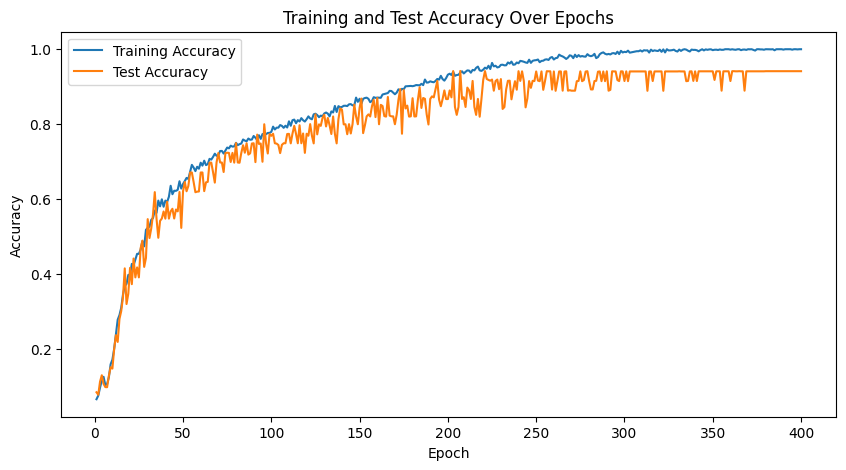

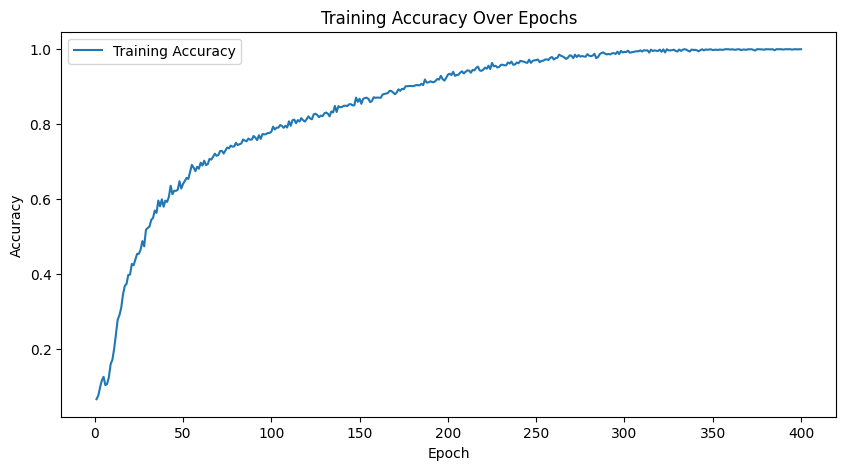

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# Convert the numpy arrays to PyTorch tensors
#train_X = torch.from_numpy(train_cls_X).float()
#train_Y = torch.from_numpy(train_Y).long()
#test_X = torch.from_numpy(test_cls_X).float()
#test_Y = torch.from_numpy(test_Y).long()

# Create a DataLoader for the training set
train_dataset = TensorDataset(train_X, train_Y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the neural network model
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
input_dim = train_X.size(1)  # Dimension of the input features
output_dim = 32  # Number of classes
model = SimpleClassifier(input_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.75)

# Lists to store the training loss and accuracy for each epoch
train_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 400

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    corrects = 0
    total_samples = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)

    # Calculate the epoch loss and accuracy on the training set
    epoch_loss = running_loss / total_samples
    epoch_accuracy = corrects.double() / total_samples

    # Append to the lists for plotting
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        outputs = model(test_X)
        _, pred_hy = torch.max(outputs, 1)
        acc_hy = accuracy_score(test_Y.numpy(), pred_hy.numpy())
        test_accuracies.append(acc_hy)

    print('Epoch {}/{} Loss: {:.4f} Train Acc: {:.4f} Test Acc: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_accuracy, acc_hy))

    # Update the learning rate scheduler
    scheduler.step()


# Plotting the training and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy Over Epochs')
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy Over Epochs')
plt.show()


In [73]:
clf2_hy = DecisionTreeClassifier().fit(train_cls_X, train_Y)
pred2_hy = clf2_hy.predict(test_cls_X)
acc2_hy = accuracy_score(test_Y, pred2_hy)
print("Decision Tree-based Ensemble Accuracy: ", acc2_hy)

Decision Tree-based Ensemble Accuracy:  0.9693574958813839


In [75]:
clf3_hy = RandomForestClassifier().fit(train_cls_X, train_Y)
pred3_hy = clf3_hy.predict(test_cls_X)
acc3_hy = accuracy_score(test_Y, pred3_hy)
print("Random Forest-based Ensemble Accuracy: ", acc3_hy)

Random Forest-based Ensemble Accuracy:  0.9779242174629325


In [76]:
clf4_hy = xgb.XGBClassifier().fit(train_cls_X, train_Y)
pred4_hy = clf4_hy.predict(test_cls_X)
acc4_hy = accuracy_score(test_Y, pred4_hy)
print("XGBoost-based Ensemble Accuracy: ", acc4_hy)

XGBoost-based Ensemble Accuracy:  0.9789126853377266


In [78]:
clf5_hy = GaussianNB().fit(train_cls_X, train_Y)
pred5_hy = clf5_hy.predict(test_cls_X)
acc5_hy = accuracy_score(test_Y, pred5_hy)
print("Naive Bayes-based Ensemble Accuracy: ", acc5_hy)

Naive Bayes-based Ensemble Accuracy:  0.9476112026359144


In [79]:
base_classifier = DecisionTreeClassifier()
clf6_hy = AdaBoostClassifier(base_estimator=base_classifier).fit(train_cls_X, train_Y)
pred6_hy = clf6_hy.predict(test_cls_X)
acc6_hy = accuracy_score(test_Y, pred6_hy)
print("AdaBoost-based Ensemble Accuracy: ", acc6_hy)

AdaBoost-based Ensemble Accuracy:  0.9584843492586491


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [80]:
clf7_hy = KNeighborsClassifier(n_neighbors=2).fit(train_cls_X, train_Y)
pred7_hy = clf7_hy.predict(test_cls_X)
acc7_hy = accuracy_score(test_Y, pred7_hy)
print("Decision Tree-based Ensemble Accuracy: ", acc7_hy)

Decision Tree-based Ensemble Accuracy:  0.942668863261944


In [81]:
clf8_hy = NearestCentroid().fit(train_cls_X, train_Y)
pred8_hy = clf8_hy.predict(test_cls_X)
acc8_hy = accuracy_score(test_Y, pred8_hy)
print("Nearest Centroid-based Ensemble Accuracy: ", acc8_hy)

Nearest Centroid-based Ensemble Accuracy:  0.9436573311367381
